# APPM X720 Biweekly Report

### *Alexey Yermakov*
### *April 5, 2022*

# Summary

For this report I take a close look at BERT and RoBERTa. This report is action-packed with looking at BERT on a model level, doing data pre-processing, performing model pre-training, attaching a head to RoBERTa, and finally observing how the model performs.

# Main Content

For this report, I wanted to explore BERT through [RoBERTa](https://arxiv.org/pdf/1907.11692.pdf), which is a "replication study of BERT". The authors of RoBERTa are from Facebook AI and and University of Washington. I decided to use RoBERTa after Dr. Raissi's comment in class that there was a nice repository available online to use it. Any code block I have will specify if it is my code or not.

### **Understanding the architecture**

I started out by re-reading the ["Attention Is All You Need"](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) paper which introduces NLP transformers. Recall that the encoder-decoder architecture looks like so:

<img src="./Images/Transformer.png" alt="Transformer" width="700">

The left part of the figure is the encoder, which is used in BERT, and the right part is the decoder, which is used in GPT. Since this report looks at RoBERTa, we're going to be dealing with the left part of the figure. In trying to understand this architecture, I made a helpful figure of what the positional embeddings look like. The paper gives a nice formula, but essentially what's happening is you get a sine wave across the dimensions of the model:

<img src="./Images/PositionEmbedding.png" alt="Positional Embedding" width="700"> 

I don't have a good intuition as to *why* this helps the model learn the position, but [this video](https://www.youtube.com/watch?v=iDulhoQ2pro) does a decent job of a reasonable sounding answer. Essentially, the model learns that different values added to the embedding matrix represent different positions for the model, which is exactly what we want the position embedding to be doing.

Anyways, going through the details of the architecture, I made a detailed flow chart showing all of the math and intermediate matrix sizes that goes into the encoder part of the transformer. The decoder part can be understood much more easily as well, but that's for GPT and not the focus of this report. Hopefully this figure helps, since explaining the model in words would be much harder. I color coded the blocks to match the encoder from the "Attention Is All You Need" paper. Also, note that "x" is a matrix multiplication and "\*" is a scalar multiplication.

<img src="./Images/detailed_encoder.png" alt="Encoder Flow Chart" width="900"> 

Once we understand what the encoder does, we can look at a higher-level view of BERT with L=3 encoder layers.

<img src="./Images/N=3.png" alt="N=3 model" width="500"> 

There are three main hyperparameters used in the BERT model. `L`, which is the number of encoders, `H`, which is the hidden dimension of the encoders, and `A`, which is the number of self-attention heads in the multi-head attention blocks of each encoder. BERT-base has L=12, H=768, and A=12 for a total of 110 million parameters (source: [BERT paper](https://arxiv.org/pdf/1905.05950.pdf)). BERT-large has L=24, H=1024, and A=16 for a total of 340 million parameters (source: [BERT paper](https://arxiv.org/pdf/1905.05950.pdf)). There is also another parameter which isn't really mentioned, which is the number of input/output tokens T, but conventionally that value is T=512.

Now that we understand the BERT architecture, I'll move on to using it!

## **Pre-Training the Model**


I found [this nice tutorial](https://github.com/facebookresearch/fairseq/blob/main/examples/roberta/README.pretraining.md) on how to pre-train RoBERTa. I first cloned the [fairseq](https://github.com/facebookresearch/fairseq) repository, which contained the code from the [RoBERTa paper](https://arxiv.org/pdf/1907.11692.pdf). For this section, the below commands were run from the top-most directory of this repository.

#### **Pre-Processing/BPE**

First, we download the [`wikitext 2013` dataset](https://huggingface.co/datasets/wikitext).

```bash
# This is not my code, the code is from the tutorial
wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
unzip wikitext-103-raw-v1.zip
```

and then we encode it with GPT-2 BPE, which is a variant of Byte Pair Encoding.

```bash
# This is not my code, the code is from the tutorial
mkdir -p gpt2_bpe
wget -O gpt2_bpe/encoder.json https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json
wget -O gpt2_bpe/vocab.bpe https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/vocab.bpe
for SPLIT in train valid test; do \
    python -m examples.roberta.multiprocessing_bpe_encoder \
        --encoder-json gpt2_bpe/encoder.json \
        --vocab-bpe gpt2_bpe/vocab.bpe \
        --inputs wikitext-103-raw/wiki.${SPLIT}.raw \
        --outputs wikitext-103-raw/wiki.${SPLIT}.bpe \
        --keep-empty \
        --workers 60; \
done
```

What this does is take in the `wikitext-103-raw` dataset for each split of `train`, `valid`, and `test` and

1) Split each byte apart, giving us our initial tokenization
2) use the pre-computed merges in `gpt2_bpe/vocab.bpe` to merge the bytes (based on merges used when GPT2 was trained for that paper)
3) Convert each token into an integer from `gpt_bpe/encoder.json` (this is just a mapping from words to integers)

It's important to note that GPT-2 used byte level encoding in its literal sense instead of characters, since [unicode](https://en.wikipedia.org/wiki/Unicode) characters can take up more than a single byte (see [UTF-23](https://en.wikipedia.org/wiki/UTF-32)).

Anyways, after running the above code we can compare the data from the files.

`wiki.valid.raw`
```
 = Homarus gammarus = 
 
 Homarus gammarus , known as the European lobster or common lobster , is a species of clawed lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming " lobster red " on cooking . Mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into planktonic larvae . Homarus gammarus is a highly esteemed food , and is widely caught using lobster pots , mostly around the British Isles . 
```

`wiki.valid.bpe`
```
28 8074 20272 9106 3876 385 796

28718 20272 9106 3876 385 837 1900 355 262 3427 43657 393 2219 43657 837 318 257 4693 286 26573 276 43657 422 262 10183 10596 10692 837 19517 6896 290 3354 286 262 2619 6896 764 632 318 7173 3519 284 262 1605 43657 837 367 13 45630 41141 764 632 743 1663 284 257 4129 286 3126 12067 357 1987 287 1267 290 257 2347 286 718 37075 357 1511 18360 1267 837 290 13062 257 39089 5166 286 28421 764 554 1204 837 262 6804 5937 389 4171 837 691 5033 366 43657 2266 366 319 10801 764 337 803 8833 287 262 3931 837 9194 9653 543 389 5281 416 262 12366 329 510 284 257 614 878 289 19775 656 39599 1122 291 37346 764 8074 20272 9106 3876 385 318 257 4047 48243 2057 837 290 318 6768 4978 1262 43657 32195 837 4632 1088 262 3517 36217 764
```

Great! So BPE worked. However, there's one more step before we can train the model:

```bash
# This is not my code, the code is from the tutorial
wget -O gpt2_bpe/dict.txt https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/dict.txt
fairseq-preprocess \
    --only-source \
    --srcdict gpt2_bpe/dict.txt \
    --trainpref wikitext-103-raw/wiki.train.bpe \
    --validpref wikitext-103-raw/wiki.valid.bpe \
    --testpref wikitext-103-raw/wiki.test.bpe \
    --destdir data-bin/wikitext-103 \
    --workers 4 # I changed this from 60 to 4 since I don't have a super computer
```

The point of this is to "pre-process" the generated BPE files from before (like `wiki.valid.bpe`) to something that the model can expect as input. The output files are binary and can't be read in a text editor. In all honestly I'm not 100% sure what this does, but it's not the focus of this report so I will just take it as it is. The [file](https://github.com/facebookresearch/fairseq/blob/main/fairseq_cli/preprocess.py) that runs this code isn't super well documented either `:(`. Regardless, this process is necessary to pre-train RoBERTa on the wikitext103 dataset.

#### **Pre-Training RoBERTa**

The next piece of code given to me in the tutorial is to train RoBERTa.

```bash
# This is not my code, the code is from the tutorial
DATA_DIR=data-bin/wikitext-103

fairseq-hydra-train -m --config-dir examples/roberta/config/pretraining --config-name base task.data=$DATA_DIR checkpoint.restore_file=./roberta.base/model.pt 2>&1 | tee run.txt
```

Unfortunately, this code *does not work*! I get the following error:

```bash
FileNotFoundError: [Errno 2] No such file or directory: 'data-bin/wikitext-103/dict.txt'
```

but the file *does* exist:

```bash
$ls -al data-bin/wikitext-103/dict.txt 
-rw-r--r-- 1 alexey 590K Mar 19 14:02 data-bin/wikitext-103/dict.txt
```

Strange. Using the absolute path fixed this:

```bash
DATA_DIR='/home/alexey/Desktop/fairseq/data-bin/wikitext-103/'
```

I stopped the training because I need to configure the hyper-parameters of the training method to account for my measly 1-GPU computer with an NVIDIA 1070 graphics card with 4GB of memory `c:`.

```
(from running RoBERTA)
[2023-03-19 17:13:44,795][fairseq.utils][INFO] - rank   0: capabilities =  6.1  ; total memory = 7.921 GB ; name = NVIDIA GeForce GTX 1070
```

```
(from the tutorial page)
Note: The above command assumes training on 8x32GB V100 GPUs
```

The `base` architecture of RoBERTa from the file `model.py` is the following:

```bash
# NOT MY CODE! Code from fairseq/models/roberta/model.py
@register_model_architecture("roberta", "roberta")
def base_architecture(args):
    args.encoder_layers = safe_getattr(args, "encoder_layers", 12)
    args.encoder_embed_dim = safe_getattr(args, "encoder_embed_dim", 768)
    args.encoder_ffn_embed_dim = safe_getattr(args, "encoder_ffn_embed_dim", 3072)
    args.encoder_attention_heads = safe_getattr(args, "encoder_attention_heads", 12)

    args.dropout = safe_getattr(args, "dropout", 0.1)
    args.attention_dropout = safe_getattr(args, "attention_dropout", 0.1)
    args.activation_dropout = safe_getattr(args, "activation_dropout", 0.0)
    args.pooler_dropout = safe_getattr(args, "pooler_dropout", 0.0)

    args.max_source_positions = safe_getattr(args, "max_positions", 512)
    args.no_token_positional_embeddings = safe_getattr(
        args, "no_token_positional_embeddings", False
    )

    # BERT has a few structural differences compared to the original Transformer
    args.encoder_learned_pos = safe_getattr(args, "encoder_learned_pos", True)
    args.layernorm_embedding = safe_getattr(args, "layernorm_embedding", True)
    args.no_scale_embedding = safe_getattr(args, "no_scale_embedding", True)
    args.activation_fn = safe_getattr(args, "activation_fn", "gelu")
    args.encoder_normalize_before = safe_getattr(
        args, "encoder_normalize_before", False
    )
    args.pooler_activation_fn = safe_getattr(args, "pooler_activation_fn", "tanh")
    args.untie_weights_roberta = safe_getattr(args, "untie_weights_roberta", False)

    # Adaptive input config
    args.adaptive_input = safe_getattr(args, "adaptive_input", False)

    # LayerDrop config
    args.encoder_layerdrop = safe_getattr(args, "encoder_layerdrop", 0.0)
    args.encoder_layers_to_keep = safe_getattr(args, "encoder_layers_to_keep", None)

    # Quantization noise config
    args.quant_noise_pq = safe_getattr(args, "quant_noise_pq", 0)
    args.quant_noise_pq_block_size = safe_getattr(args, "quant_noise_pq_block_size", 8)
    args.quant_noise_scalar = safe_getattr(args, "quant_noise_scalar", 0)

    # R4F config
    args.spectral_norm_classification_head = safe_getattr(
        args, "spectral_norm_classification_head", False
    )
```

The `base` training hyper-parameters of RoBERTa are from the file `base.yaml` and are the following:

```yaml
# NOT MY CODE! Code from `examples/roberta/config/pretraining/base.yaml`
# @package _group_
common:
  fp16: false
  log_format: json
  log_interval: 200

checkpoint:
  no_epoch_checkpoints: true

task:
  _name: masked_lm
  data: ???
  sample_break_mode: complete
  tokens_per_sample: 512

criterion: masked_lm

dataset:
  batch_size: 16
  ignore_unused_valid_subsets: true

optimizer:
  _name: adam
  weight_decay: 0.01
  adam_betas: (0.9,0.98)
  adam_eps: 1e-06

lr_scheduler:
  _name: polynomial_decay
  warmup_updates: 10000

optimization:
  clip_norm: 0
  lr: [0.0005]
  max_update: 125000
  update_freq: [16]

model:
  _name: roberta
  max_positions: 512
  dropout: 0.1
  attention_dropout: 0.1
```

I scaled the architecture to have a smaller hidden dimension, less encoder layers, and less attention heads. I pre-trained two models, one with an inverted bottleneck in the Feed Forward block (which is what's normally in the model) and one with a bottleneck (which is not what's typical). The bottleneck was an idea that Dr. Raissi gave me when I met with him in office hours, to observe the effect of the bottleneck. I also modified the pre-training hyper-parameters to learn faster (`lr`), a smaller batch size (`batch_size`), and more "gradient accumulation" (`update_freq`). What is "gradient accumulation"? The `README.pretraining.md` explains it better than I can:

```
(from the tutorial page)
**Note:** Each GPU uses
a batch size of 16 sequences (`dataset.batch_size`) and accumulates gradients to
further increase the batch size by 16x (`optimization.update_freq`), for a total batch size
of 2048 sequences. If you have fewer GPUs or GPUs with less memory you may need
to reduce `dataset.batch_size` and increase dataset.update_freq to compensate.
Alternatively if you have more GPUs you can decrease `dataset.update_freq` accordingly
to increase training speed.
```

So, I did exactly what it said for less GPUs.

This change caused the number of updates `S` to go from `1,000,000` in the original report down to `125,000`. However, given the amount of time this took to train (2 days for Model 1 and 4 days for Model 2), I think this is ok lol.

Since the above code dump is kind of gross, I made some nice tables!

 <table>
  <tr>
    <th>Model Hyper Parameter</th>
    <th>RoBERTa Base</th>
    <th>Custom Model 1</th>
    <th>Custom Model 2</th>
  </tr>
  <tr>
    <td>Encoder (L)ayers</td>
    <td>12</td>
    <td>1</td>
    <td>1</td>
  </tr>
  <tr>
    <td>Attention (H)eads</td>
    <td>12</td>
    <td>3</td>
    <td>3</td>
  </tr>
  <tr>
    <td>Hidden Dimension (A)</td>
    <td>768</td>
    <td>192</td>
    <td>768</td>
  </tr>
  <tr>
    <td>FFN Dimension</td>
    <td>3072</td>
    <td>768</td>
    <td>192</td>
  </tr>
  <tr>
    <td>(T)okens</td>
    <td>512</td>
    <td>512</td>
    <td>512</td>
  </tr>
  <tr>
    <td>Total Parameters</td>
    <td>110M</td>
    <td>10M</td>
    <td>42M</td>
  </tr>
</table> 

 <table>
  <tr>
    <th>Training Hyper Parameter</th>
    <th>RoBERTa Base</th>
    <th>Custom Model 1 and 2</th>
  </tr>
  <tr>
    <td>fp16</td>
    <td>true</td>
    <td>false</td>
  </tr>
  <tr>
    <td>batch_size</td>
    <td>16</td>
    <td>4</td>
  </tr>
  <tr>
    <td>lr</td>
    <td>0.0005</td>
    <td>0.0007</td>
  </tr>
  <tr>
    <td>update_freq</td>
    <td>16</td>
    <td>64</td>
  </tr>
</table> 

The results from training my custom models are shown below (I got the loss values from parsing `runXXX.txt` in my `pre_training_output/` directory using `parse.py` in the same folder). I first import my libraries then make some plots.

In [4]:
import torch
from datasets import load_dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt

print("GPU Available?",torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

GPU Available? True


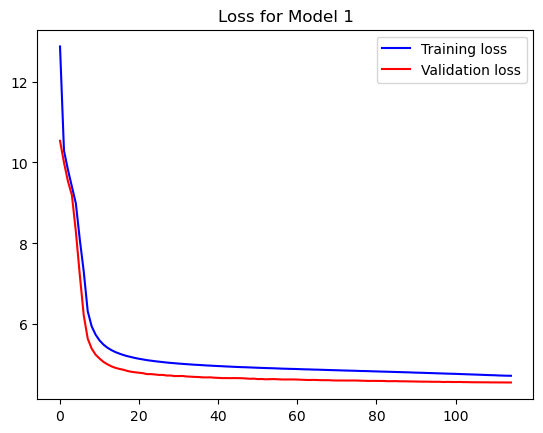

Final training loss: 4.725
Final validation loss: 4.559
Epoch 59 training loss: 4.896
Epoch 59 validation loss: 4.634


In [29]:
train_loss_1 = [12.869, 10.294, 9.821, 9.404, 8.99, 8.096, 7.3, 6.324, 5.947, 5.741, 5.598, 5.495, 5.418, 5.359, 5.311, 5.273, 5.239, 5.211, 5.187, 5.164, 5.145, 5.128, 5.111, 5.098, 5.085, 5.074, 5.063, 5.052, 5.043, 5.035, 5.026, 5.019, 5.012, 5.005, 4.998, 4.993, 4.987, 4.98, 4.976, 4.97, 4.965, 4.961, 4.955, 4.951, 4.946, 4.942, 4.938, 4.935, 4.931, 4.927, 4.923, 4.919, 4.916, 4.913, 4.91, 4.906, 4.902, 4.899, 4.896, 4.894, 4.891, 4.887, 4.884, 4.882, 4.878, 4.876, 4.873, 4.87, 4.867, 4.864, 4.861, 4.858, 4.855, 4.852, 4.85, 4.847, 4.843, 4.842, 4.839, 4.835, 4.833, 4.829, 4.827, 4.824, 4.821, 4.818, 4.816, 4.812, 4.81, 4.806, 4.802, 4.8, 4.797, 4.793, 4.791, 4.787, 4.784, 4.781, 4.777, 4.775, 4.772, 4.768, 4.765, 4.761, 4.758, 4.754, 4.751, 4.747, 4.743, 4.74, 4.737, 4.732, 4.729, 4.726, 4.725]
valid_loss_1 = [10.537, 10.0, 9.537, 9.192, 8.297, 7.219, 6.22, 5.645, 5.397, 5.246, 5.15, 5.067, 5.008, 4.958, 4.921, 4.895, 4.874, 4.845, 4.824, 4.811, 4.8, 4.788, 4.766, 4.766, 4.757, 4.746, 4.746, 4.731, 4.731, 4.717, 4.718, 4.72, 4.707, 4.703, 4.697, 4.694, 4.686, 4.684, 4.686, 4.677, 4.673, 4.667, 4.668, 4.666, 4.668, 4.666, 4.665, 4.658, 4.651, 4.654, 4.643, 4.645, 4.638, 4.641, 4.643, 4.639, 4.634, 4.633, 4.634, 4.634, 4.631, 4.627, 4.623, 4.62, 4.623, 4.62, 4.616, 4.616, 4.615, 4.61, 4.608, 4.608, 4.608, 4.607, 4.608, 4.607, 4.603, 4.601, 4.597, 4.599, 4.598, 4.597, 4.596, 4.59, 4.592, 4.592, 4.588, 4.588, 4.586, 4.584, 4.583, 4.58, 4.579, 4.579, 4.576, 4.576, 4.576, 4.57, 4.574, 4.571, 4.57, 4.572, 4.568, 4.568, 4.565, 4.564, 4.564, 4.563, 4.563, 4.561, 4.561, 4.56, 4.56, 4.559, 4.559]

plt.plot(train_loss_1, label='Training loss', color='blue')
plt.plot(valid_loss_1, label="Validation loss", color='red')
plt.title('Loss for Model 1')
plt.legend()
plt.show()

print("Final training loss:", train_loss_1[-1])
print("Final validation loss:", valid_loss_1[-1])

print("Epoch 59 training loss:", train_loss_1[58])
print("Epoch 59 validation loss:", valid_loss_1[58])

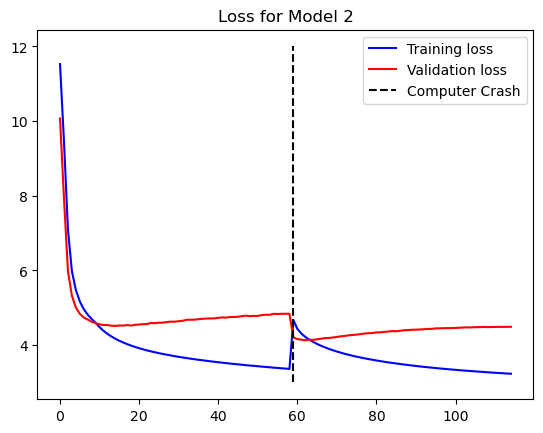

Final training loss: 3.235
Final validation loss: 4.492
Epoch 59 training loss: 3.363
Epoch 59 validation loss: 4.839


In [30]:
train_loss_2 = [11.528, 9.46, 7.1, 5.985, 5.478, 5.172, 4.965, 4.816, 4.701, 4.599, 4.482, 4.384, 4.302, 4.232, 4.171, 4.117, 4.07, 4.026, 3.987, 3.951, 3.918, 3.888, 3.859, 3.833, 3.809, 3.785, 3.764, 3.744, 3.724, 3.705, 3.687, 3.67, 3.654, 3.638, 3.623, 3.608, 3.595, 3.581, 3.567, 3.555, 3.542, 3.531, 3.519, 3.507, 3.496, 3.486, 3.475, 3.463, 3.454, 3.445, 3.435, 3.425, 3.416, 3.407, 3.397, 3.389, 3.38, 3.372, 3.363, 4.671, 4.436, 4.313, 4.222, 4.149, 4.087, 4.032, 3.983, 3.94, 3.899, 3.863, 3.829, 3.798, 3.768, 3.741, 3.715, 3.691, 3.669, 3.647, 3.627, 3.608, 3.589, 3.572, 3.554, 3.538, 3.524, 3.509, 3.494, 3.481, 3.467, 3.455, 3.442, 3.43, 3.418, 3.407, 3.397, 3.386, 3.376, 3.366, 3.357, 3.347, 3.339, 3.329, 3.321, 3.313, 3.305, 3.297, 3.289, 3.282, 3.274, 3.267, 3.26, 3.253, 3.247, 3.24, 3.235]
valid_loss_2 = [10.07, 7.939, 5.986, 5.327, 5.008, 4.84, 4.739, 4.686, 4.628, 4.588, 4.557, 4.539, 4.538, 4.521, 4.515, 4.527, 4.523, 4.537, 4.525, 4.545, 4.553, 4.562, 4.564, 4.594, 4.588, 4.601, 4.602, 4.618, 4.63, 4.628, 4.641, 4.652, 4.679, 4.68, 4.683, 4.695, 4.705, 4.713, 4.715, 4.717, 4.732, 4.742, 4.737, 4.754, 4.754, 4.76, 4.778, 4.789, 4.776, 4.784, 4.783, 4.803, 4.815, 4.812, 4.84, 4.834, 4.839, 4.841, 4.839, 4.207, 4.161, 4.146, 4.132, 4.145, 4.142, 4.157, 4.172, 4.19, 4.193, 4.205, 4.22, 4.237, 4.247, 4.263, 4.273, 4.282, 4.296, 4.31, 4.32, 4.324, 4.341, 4.343, 4.356, 4.364, 4.377, 4.37, 4.386, 4.4, 4.403, 4.413, 4.414, 4.42, 4.425, 4.435, 4.435, 4.45, 4.45, 4.455, 4.456, 4.456, 4.461, 4.466, 4.473, 4.476, 4.475, 4.481, 4.482, 4.487, 4.483, 4.485, 4.487, 4.489, 4.489, 4.49, 4.492]

plt.plot(train_loss_2, label='Training loss', color='blue')
plt.plot(valid_loss_2, label="Validation loss", color='red')
plt.vlines(59,3,12, color='black', label='Computer Crash', linestyle='--')
plt.title('Loss for Model 2')
plt.legend()
plt.show()

print("Final training loss:", train_loss_2[-1])
print("Final validation loss:", valid_loss_2[-1])

print("Epoch 59 training loss:", train_loss_2[58])
print("Epoch 59 validation loss:", valid_loss_2[58])

Fascinating! So first of all, I'm really glad with the first figure's curves, it shows that pre-training process works (thank goodness!) and that the model is getting better with each epoch. Further, we see that the validation loss is *better* than the training loss! This is interesting since my model is a shell of the RoBERTa base model, yet it's still performing well.

What I found most interesting is the second model. The spike around epoch 60 is unfortunately because my computer crashed during the training process. Since I don't have a spare computer, I was using my desktop while it was training for other things. Maybe it was for Minecraft, maybe not, we will never know... (it **was** for Minecraft). However, the Facebook code has a checkpoint feature where the model state is saved and training can be resumed. It's clear, however, that this doesn't save everything since the loss curve acts strangely around epoch 60. I believe this to be because the Adam optimizer is used with weight decay, and restarting the training process at epoch 60 reset the weight decay, causing the loss to behave strangely.

Before my computer crashed, though, we can see that the validation loss is getting worse, showing model over-fitting. I think this is because the bottleneck in the feed forward block is causing information loss.

Thus, we can heuristically conclude that the bottle-necked model (Custom Model 2) is performing overall *worse* than the inverted-bottleneck model despite the final loss being better. I believe this conclusion is true since model 2's final validation loss is almost higher than model 1's. Model 2's validation loss *is* higher than model 1's at epoch 59, when my computer crashed. What's fascinating is we came to the conclusion that model 2 is worse than model 1 despite the total number of parameters being larger for model 2 than for model 1, at about 4x as many. This is because the hidden dimension and the feed-forward dimensions are swapped between the two models. So, I think it's fair to conclude that the inverted bottleneck layer is really helpful for model performance.

## Attaching a head

Now that we have a suitable pre-trained model, I would like to be able to attach a head and get some downstream task working. I decided to challenge myself and try working with [SQuAD 1.1](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/), which is a question-answering dataset. Each data point has a question and a "context" paragraph within which the answer appears, and the job of the model is to provide a start and end index for where in the "context" the answer to the question appears. SQuAD 1.1 always has an answer where-as SQuAD 2.0 sometimes has questions which are unanswerable. I will use SQuAD 1.1 since it's a tad bit easier to work with. I'll first apply the head to a pre-trained model from Facebook (since I can expect it to perform better than my model above) and then I'll apply it to my own model and compare.

Now, moving on to the coding.

I will be sample code from the [RoBERTa](https://github.com/facebookresearch/fairseq/tree/main/examples/roberta) repository. I'll first load a RoBERTa model with the BERT-base parameters (L=12, H=768, and A=12).

In [15]:
# Code is not mine! Copied (and modified to roberta.base instead of roberta.large) from here:
# https://github.com/facebookresearch/fairseq/tree/main/examples/roberta
input_len = 512 # Max number of input tokens to the RoBERTa model
roberta = torch.hub.load('pytorch/fairseq', 'roberta.base')
roberta.eval() # disable dropout (or leave in train mode to finetune)
roberta.cuda() # Move RoBERTa to GPU
None

Using cache found in /home/alexey/.cache/torch/hub/pytorch_fairseq_main
2023-04-02 11:27:51 | INFO | fairseq.file_utils | loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.base.tar.gz from cache at /home/alexey/.cache/torch/pytorch_fairseq/37d2bc14cf6332d61ed5abeb579948e6054e46cc724c7d23426382d11a31b2d6.ae5852b4abc6bf762e0b6b30f19e741aa05562471e9eb8f4a6ae261f04f9b350
2023-04-02 11:27:53 | INFO | fairseq.tasks.masked_lm | dictionary: 50264 types
2023-04-02 11:27:55 | INFO | fairseq.models.roberta.model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 25, 'log_format': 'json', 'log_file': None, 'aim_repo': None, 'aim_run_hash': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': True, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 4, 'fp16_scale_window': 128, 'fp16_scale

When working with this model, whenever we pass in information (a string, a sentence, or a list of strings/sentences) we want it to be encoded. Below is an example of what encoding looks like.

In [5]:
def encode_example():
    input_list = ['Hello world!', 'goodbye world!']
    print("Encoding", input_list, ":")
    print()
    print("Encoded version:")
    tokens = roberta.encode(*input_list)
    print(tokens)
    print()
    print("Decoded back to", roberta.decode(tokens))

with torch.no_grad():
    encode_example()

Encoding ['Hello world!', 'goodbye world!'] :

Encoded version:
tensor([    0, 31414,   232,   328,     2,     2,  8396, 33542,   232,   328,
            2])

Decoded back to ['Hello world!', 'goodbye world!']


Easy enough! Through trial and error I found that the following tokens exist:

The ones from the dictionary (`gpt2_bpe/dict.txt`):

```
13 850314647
262 800385005
11 800251374
284 432911125
...
```

where each token from the previous code block (ex. `31414`) indexes into `dict.txt` *by row* and gives an integer (first column) which can be decoded from `gpt2_bpe/encoder.json`:

```
{"!": 0, "\"": 1, "#": 2, "$": 3, "%": 4, "&": 5, "'": 6, "(": 7, ")": 8, "*": 9, "+": 10, ",": 11, "-": 12, ".": 13, "/": 14, "0": 15, "1": 16, "2": 17, "3": 18, "4": 19, "5": 20, "6": 21, "7": 22, "8": 23, "9": 24, ":": 25, ";": 26, "<": 27, "=": 28, ">": 29, "?": 30, "@": 31, "A": 32, "B": 33, "C": 34, "D": 35, "E": 36, "F": 37, "G": 38, "H": 39, "I": 40, "J": 41, "K": 42, "L": 43, "M": 44, "N": 45, "O": 46, "P": 47, "Q": 48, "R": 49, "S": 50, "T": 51, "U": 52, "V": 53, "W": 54, "X": 55, "Y": 56, "Z": 57, "[": 58, "\\": 59, "]": 60, "^": 61, "_": 62, "`": 63, ...
```

The second column of `dict.txt` is the frequency of the token during the GPT2 BPE process (which again, was pre-computed). Through trial and error I found four extra tokens that were not in the dictionary.

A `<start>` token indicating the start of a sentence.  
A `<end>` token indicating the end of a sentence.  
A `<mask>` token indicating a masked token (used during pre-training).  
A `<pad>` token for input padding.

```
0: <start>  
1: <pad>  
2: <end>  
3-50263: dictionary
50264: <mask>
```

Now that we can use tokenize our input, we can observe how the RoBERTa model formats its output.

To put a head on the model, I need to know what the output of the last layer of RoBERTa looks like. To this end, I used examples from the [RoBERTa repo](https://github.com/facebookresearch/fairseq/tree/main/examples/roberta) to help out.

In [8]:
def extract_features_example():
    for input_list in ['Hello world!', 'goodbye world!']:
        print(f"Input is '{input_list}'")
        tokens = roberta.encode(*input_list)
        print("Tokens are:")
        print(tokens)
        print("Of size:")
        print(tokens.shape)
        last_layer_features = roberta.extract_features(tokens)
        print("RoBERTa output is:")
        print(last_layer_features)
        print("Of size:")
        print(last_layer_features.shape)
        print()
    
with torch.no_grad():
    extract_features_example()

Input is 'Hello world!'
Tokens are:
tensor([   0,  725,    2,    2,  242,    2,    2,  462,    2,    2,  462,    2,
           2,  139,    2,    2, 1437,    2,    2,  605,    2,    2,  139,    2,
           2,  338,    2,    2,  462,    2,    2,  417,    2,    2,  328,    2])
Of size:
torch.Size([36])
RoBERTa output is:
tensor([[[-0.0540,  0.0623, -0.0063,  ..., -0.0639, -0.0850, -0.0029],
         [-0.0173, -0.2597,  0.1312,  ...,  0.1381,  0.0548, -0.0518],
         [-0.0579,  0.0434, -0.0455,  ..., -0.1328, -0.1057, -0.0329],
         ...,
         [ 0.0810, -0.3107,  0.2950,  ...,  0.2949, -0.1659, -0.1569],
         [-0.0691, -0.2388, -0.1425,  ..., -0.2976, -0.1276,  0.0167],
         [-0.0580,  0.0433, -0.0455,  ..., -0.1327, -0.1058, -0.0329]]],
       device='cuda:0')
Of size:
torch.Size([1, 36, 768])

Input is 'goodbye world!'
Tokens are:
tensor([   0,  571,    2,    2,  139,    2,    2,  139,    2,    2,  417,    2,
           2,  428,    2,    2,  219,    2,    2,  242,    

Great! So it's pretty easy to get the last layer's output. However, you should notice that the output size is not the same, which is going to be a problem when adding a head to the model. We want all of the 512 positions for the input of the BERT architecture to be available for the model to choose when selecting the `start` and `end` positions of the "context" paragraph for question-answering. I'll fix this, but first let's download the SQuAD dataset. I used Hugging Face's [SQuAD](https://huggingface.co/datasets/squad) dataset, which is very easy to download.

In [3]:
dataset = load_dataset("squad")

2023-03-25 19:18:33 | WARNING | datasets.builder | Found cached dataset squad (/home/alexey/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Let's see what we're dealing with by examining the structure of the dataset:

In [4]:
print(dataset)
print()
print(dataset['train'][80000])

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

{'id': '57301a88b2c2fd1400568878', 'title': 'Liberia', 'context': 'The Americo-Liberian settlers did not identify with the indigenous peoples they encountered, especially those in communities of the more isolated "bush." They knew nothing of their cultures, languages or animist religion. Encounters with tribal Africans in the bush often developed as violent confrontations. The colonial settlements were raided by the Kru and Grebo people from their inland chiefdoms. Because of feeling set apart and superior by their culture and education to the indigenous peoples, the Americo-Liberians developed as a small elite that held on to political power. It excluded the indigenous tribesmen from birthright citizenship in their own lands

So the dataset is basically a huge JSON file, making it easy to parse. It has two splits, `train` and `validation` which each contain data. I'll primarily just be using the `context`, `question`, and `answers` sections for my model. The `context` contains the `answer` to the `question`.

What I do next is make some helper functions to tokenize the dataset. Tokenizing the data points is tricky because, as mentioned in [this article](https://towardsdatascience.com/how-to-train-bert-for-q-a-in-any-language-63b62c780014):

> Our targets are the start and end positions of the answer, which we previously built using the *character* start and end positions within the `context` strings. However, we will be feeding tokens into Bert, so we need to provide the *token* start and end positions.

So, I want to convert `answer_start` from the dataset from a character index to a token index. I cheated a bit and tokenized everything before the answer and everything after the answer separately and combined the two lists. This then allowed me to get the token start index by the length of the "before the answer" tokens. This might cause some performance loss since this method of tokenization isn't how the entire data point will always be tokenized.

If this isn't clear, the main point is that the method below is how I tokenize the data and it mght not be 100% efficient. I tokenize a data point below and detokenize it to show what's going into the model.

Also, instead of the `text` segment, I use an answer length integer when tokenized so I know how many tokens are in the answer.

In [5]:
def get_squad_BPE(squad_data_pt):
    ans_idx = squad_data_pt['answers']['answer_start'][0]
    ans_chars = len(squad_data_pt['answers']['text'][0])
    
    question_text = squad_data_pt['question']
    pre_ans_text = squad_data_pt['context'][:ans_idx]
    ans_text = squad_data_pt['context'][ans_idx:ans_idx + ans_chars]
    post_ans_text = squad_data_pt['context'][ans_idx + ans_chars:]
    
    question_enc = roberta.encode(question_text)
    pre_ans_enc = roberta.encode(pre_ans_text)[:-1]
    ans_enc = roberta.encode(ans_text)[1:-1]
    post_ans_enc = roberta.encode(post_ans_text)[1:]
    
    ans_idx = len(question_enc) + len(pre_ans_enc)
    ans_len = len(ans_enc)
    
    return torch.cat([question_enc, pre_ans_enc, ans_enc, post_ans_enc]), ans_idx, ans_len

def show_squad_bpe():
    data_pt = dataset['validation'][2]
    squad_bpe, ans_idx, ans_len = get_squad_BPE(data_pt)
    print("From dataset:")
    print("\nContext:")
    print(data_pt['context'])
    print("\nAnswer:")
    print(data_pt['answers']['text'][0])
    
    print("-----------------------------")
    
    print("\nFrom BPE encoding:")
    print(roberta.decode(squad_bpe))
    print("\nAnswer:")
    print(roberta.decode(squad_bpe[ans_idx:ans_idx+ans_len]))
    
with torch.no_grad():
    show_squad_bpe()

From dataset:

Context:
Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.

Answer:
Santa Clara, California
-----------------------------

From BPE encoding:
Where did Super Bowl 50 take place?Super Bowl 50 was an American football game to determine the champion of the Natio

Great! So what we can do next is pre-process the data so that our training takes a lot less time. What I'll do is BPE encode each data point from SQuAD and pad it with `<pad>` tokens so each input is `512` token large. I'll also skip all data points which have tokens more than `512`. Below is some code which saves Python objects in binary files, this is how I'll save the data locally. It uses a neat package from python called [pickle](https://docs.python.org/3/library/pickle.html).

In [17]:
def save_object(file_name, obj):
    obj_b = pickle.dumps(obj)
    with open(file_name,'wb') as save_f:
        save_f.write(obj_b)

    return None

def load_object(file_name):
    with open(file_name,'rb') as load_f:
        obj_b = load_f.read()
        return pickle.loads(obj_b)

    return None

The code below does what I mentioned before, saving the training and validation datasets locally, ready to be used in RoBERTa.

In [7]:
def pre_process(split, save_dir):
    squad_bpes, ans_idxs, ans_lens = (None, None, None)
    
    for i in range(len(dataset[split])):
        # Convert to BPE
        data_pt = dataset[split][i]

        squad_bpe, ans_idx, ans_len = get_squad_BPE(data_pt)
        ans_idx = torch.tensor([ans_idx])
        ans_len = torch.tensor([ans_len])
        
        # Check the data point is not too large
        if len(squad_bpe) > 512:
            continue

        squad_bpe = torch.cat([squad_bpe,torch.ones(input_len-len(squad_bpe), dtype=torch.int64)])
        
        # Add to our dataset
        if i == 0:
            squad_bpes = squad_bpe
            ans_idxs = ans_idx
            ans_lens = ans_len
        else:
            squad_bpes = torch.vstack([squad_bpes, squad_bpe])
            ans_idxs = torch.hstack([ans_idxs, ans_idx])
            ans_lens = torch.hstack([ans_lens, ans_len])
    
    # Save objects
    save_object(f"{save_dir}/{split}_squad_bpes", squad_bpes)
    save_object(f"{save_dir}/{split}_ans_idxs", ans_idxs)
    save_object(f"{save_dir}/{split}_ans_lens", ans_lens)
    
with torch.no_grad():
    pre_process('validation', 'Validation')
    pre_process('train', 'Train')
    None

Now that the data is pre-processed, I actually want to batch the data to make the training even faster! From my trial and error testing of the code later in the notebook, I found that this helps a lot with run-time speed. I batch the data in groups of 32 data points.

In [8]:
def make_batches(batch_sz, split, load_dir, save_dir):
    # Load pre-processed data
    squad_bpes = load_object(f"{load_dir}/{split}_squad_bpes")
    ans_idxs = load_object(f"{load_dir}/{split}_ans_idxs")
    ans_lens = load_object(f"{load_dir}/{split}_ans_lens")
    
    # Helper variables to keep track of everything
    batch_bpe, batch_idx, batch_len = (None, None, None)
    batch_bpes, batch_idxs, batch_lens = (None, None, None)
    
    num_in_batch = 0
    
    for i in range(squad_bpes.shape[0]):
        # Accumulate the data in the batch
        if num_in_batch == 0:
            batch_bpe = squad_bpes[i]
            batch_idx = ans_idxs[i]
            batch_len = ans_lens[i]
        else:
            batch_bpe = torch.vstack([batch_bpe, squad_bpes[i]])
            batch_idx = torch.hstack([batch_idx, ans_idxs[i]])
            batch_len = torch.hstack([batch_len, ans_lens[i]])
            
        num_in_batch += 1
        
        # Stack the batches
        if num_in_batch == batch_sz:
            batch_bpe = batch_bpe.unsqueeze(0)
            batch_idx = batch_idx.unsqueeze(0)
            batch_len = batch_len.unsqueeze(0)
            
            if batch_bpes == None:
                batch_bpes = batch_bpe
                batch_idxs = batch_idx
                batch_lens = batch_len
            else:
                batch_bpes = torch.vstack([batch_bpes, batch_bpe])
                batch_idxs = torch.vstack([batch_idxs, batch_idx])
                batch_lens = torch.vstack([batch_lens, batch_len])
            
            num_in_batch = 0
            
    # Save data
    save_object(f"{save_dir}/{split}_squad_bpes", batch_bpes)
    save_object(f"{save_dir}/{split}_ans_idxs", batch_idxs)
    save_object(f"{save_dir}/{split}_ans_lens", batch_lens)

make_batches(32, 'validation', 'Validation', 'Validation_32')
make_batches(32, 'train', 'Train', 'Train_32')

The code block below shows the sizes of the batched data, verifying that the batching was successful. Thus, for validation data I have 328 sets of batches of size 32. Each input is 512 tokens long.

In [19]:
def test():
    squad_bpes = load_object('Validation_32/validation_squad_bpes')
    print("input tokens:  ", squad_bpes.shape)
    
    ans_idxs = load_object('Validation_32/validation_ans_idxs')
    print("answer indices:", ans_idxs.shape)
    
    ans_lens = load_object('Validation_32/validation_ans_lens')
    print("answer lengths:", ans_lens.shape)
    
test()

input tokens:   torch.Size([328, 32, 512])
answer indices: torch.Size([328, 32])
answer lengths: torch.Size([328, 32])


This code shows that RoBERTa can evaluate batches of inputs. Once again, I used the [RoBERTa Github Repo](https://github.com/facebookresearch/fairseq/tree/main/examples/roberta) to help with this code.

In [20]:
def test_batch():
    squad_bpes = load_object(f"Validation_32/validation_squad_bpes")
    print("dataset size (batched):", squad_bpes.shape)
    squad_bpes = squad_bpes[0]
    print("single batch size:     ", squad_bpes.shape)
    out = roberta.extract_features(squad_bpes)
    print("roberta output size:   ", out.shape)

with torch.no_grad():
    test_batch()

dataset size (batched): torch.Size([328, 32, 512])
single batch size:      torch.Size([32, 512])
roberta output size:    torch.Size([32, 512, 768])


These next few code blocks were what I used to test the various features of PyTorch I'll be using to write the head of my model. Recall that the goal of the head for SQuAD is to return the start and end index of the input tokens for the answer of the question. Since the output of the RoBERTa-base model is (768 x 512), we want two vectors:

- S, size (1 x 768), for the *start* position
- E, size (1 x 768), for the *end* position

where matrix multiplying these vectors with the RoBERTa output results in a (1 x 512) sized vector which we can soft-max to get probabilities for each input position as being either the start or end of the question. This is implemented in PyTorch as a [Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html). 

The code below implements this by having a model with two parameters, S and E, and the `forward` function takes in an example of what the output of a RoBERTa final layer is and returns the start and end logits (logits are the outputs of softmax).

A lot of the code below is inspired from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html).

In [26]:
# Define the test model
class SquadModelTest(nn.Module):
    def __init__(self):
        self.input_len = 10
        self.hidden_dim = 3
        super(SquadModelTest, self).__init__()
        
        # Our parameters which we're optimizing
        self.S = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)
        self.E = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)

    def forward(self, x):
        start = self.S @ x
        start = F.softmax(start,dim=0)
        
        end = self.E @ x
        end = F.softmax(end,dim=0)
        
        # Return logits for start and end
        return start, end

# Initialize the model
model = SquadModelTest()

# Prints showing what's going on
def SquadModelText_Prints():
    print("\nS:")
    print(model.S)
    print("\nE:")
    print(model.E)
    x1 = torch.tensor([[0.0847, 0.1499, 0.9340, 0.5284, 0.4223, 1.2086, 0.1089, 0.3661, 0.1478, 1.0801],
                       [1.3761, 0.5365, 1.3152, 0.0532, 1.0324, 1.4838, 0.0750, 0.4529, 1.1189, 1.2805],
                       [1.1872, 0.1170, 2.3401, 0.3625, 0.6703, 1.2795, 1.2705, 0.2398, 0.6365, 0.4558]])
    x2 = x1*-1*0.5
    x = torch.vstack([x1.unsqueeze(0), x2.unsqueeze(0)])
    print("\nx:")
    print(x)
    start, end = model.forward(x)
    start = start.unsqueeze(0)
    end = end.unsqueeze(0)
    print("\nstart:")
    print(start)
    print(start.shape)
    print("\nend:")
    print(end)
    print(end.shape)
    
with torch.no_grad():
    SquadModelText_Prints()


S:
Parameter containing:
tensor([0.3333, 0.3333, 0.3333], requires_grad=True)

E:
Parameter containing:
tensor([0.3333, 0.3333, 0.3333], requires_grad=True)

x:
tensor([[[ 0.0847,  0.1499,  0.9340,  0.5284,  0.4223,  1.2086,  0.1089,
           0.3661,  0.1478,  1.0801],
         [ 1.3761,  0.5365,  1.3152,  0.0532,  1.0324,  1.4838,  0.0750,
           0.4529,  1.1189,  1.2805],
         [ 1.1872,  0.1170,  2.3401,  0.3625,  0.6703,  1.2795,  1.2705,
           0.2398,  0.6365,  0.4558]],

        [[-0.0424, -0.0750, -0.4670, -0.2642, -0.2112, -0.6043, -0.0545,
          -0.1831, -0.0739, -0.5401],
         [-0.6880, -0.2682, -0.6576, -0.0266, -0.5162, -0.7419, -0.0375,
          -0.2264, -0.5594, -0.6403],
         [-0.5936, -0.0585, -1.1701, -0.1813, -0.3352, -0.6398, -0.6352,
          -0.1199, -0.3183, -0.2279]]])

start:
tensor([[[0.7898, 0.5991, 0.9084, 0.6159, 0.7432, 0.8793, 0.6742, 0.6293,
          0.7214, 0.8035],
         [0.2102, 0.4009, 0.0916, 0.3841, 0.2568, 0.1207, 0

What we see from the above is the following:
- The initialized values of the S and E vectors are 1/(N*H), this is just something I decided to use heuristically
- The sample RoBERTa `x` which I'm using as an example is batched (2 outputs), showing that this model works with batches
- The outputs for `forward` are also batched (that is, the logits for start and end)

Below, we can see that the only two parameters of the model as the S and E vectors. This is a very small head so it will be quick to train!

In [27]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([0.3333, 0.3333, 0.3333], requires_grad=True)
Parameter containing:
tensor([0.3333, 0.3333, 0.3333], requires_grad=True)


The next thing I want to define is the loss function. This was a bit hard to understand for me from the paper, however, it is seemingly correct here. The way it's calculated is the average of the Cross Entropy loss for the start and end indices. This is verified from looking at the original [BERT code](https://github.com/google-research/bert/blob/master/run_squad.py), which I realized I should look at by this [StackExchange thread](https://ai.stackexchange.com/questions/11900/understanding-how-the-loss-was-calculated-for-the-squad-task-in-bert-paper). Below I define the loss function I'll use.

In [4]:
def my_loss(start, end, start_ex, end_ex):
    loss_fn = nn.CrossEntropyLoss()
    loss1, loss2 = (loss_fn(start, start_ex), loss_fn(end, end_ex))
    loss = (loss1+loss2)*.5
    return loss

Next, I run two examples on this loss function. The first computes the loss for a single input and the second computes the loss for a b=2 batched input.

In [31]:
def run_my_loss_example_batched():
    x1 = torch.tensor([[0.0847, 0.1499, 0.9340, 0.5284, 0.4223, 1.2086, 0.1089, 0.3661, 0.1478, 1.0801],
                       [1.3761, 0.5365, 1.3152, 0.0532, 1.0324, 1.4838, 0.0750, 0.4529, 1.1189, 1.2805],
                       [1.1872, 0.1170, 2.3401, 0.3625, 0.6703, 1.2795, 1.2705, 0.2398, 0.6365, 0.4558]])
    x2 = x1*-1*0.5
    x = torch.vstack([x1.unsqueeze(0), x2.unsqueeze(0)])
    starts, ends = model.forward(x)
    start_exs = torch.tensor([1, 2])
    end_exs = torch.tensor([8, 6])
    
    loss = my_loss(starts, ends, start_exs, end_exs)
    print(loss)
    
with torch.no_grad():
    print("b=2 loss")
    run_my_loss_example_batched()

print()

def run_my_loss_example():
    x = torch.tensor([[0.0847, 0.1499, 0.9340, 0.5284, 0.4223, 1.2086, 0.1089, 0.3661, 0.1478, 1.0801],
                      [1.3761, 0.5365, 1.3152, 0.0532, 1.0324, 1.4838, 0.0750, 0.4529, 1.1189, 1.2805],
                      [1.1872, 0.1170, 2.3401, 0.3625, 0.6703, 1.2795, 1.2705, 0.2398, 0.6365, 0.4558]])
    starts, ends = model.forward(x)
    starts = starts.unsqueeze(0)
    ends = ends.unsqueeze(0)
    x = x.unsqueeze(0)
    start_exs = torch.tensor([1])
    end_exs = torch.tensor([8])
    
    loss = my_loss(starts, ends, start_exs, end_exs)
    print(loss)

with torch.no_grad():
    print("b=1 loss")
    run_my_loss_example()

b=2 loss
tensor(2.3734)

b=1 loss
tensor(2.3342)


To convince you this implementation is correct, I copied the [BERT loss code](https://github.com/google-research/bert/blob/master/run_squad.py), modified it to work in PyTorch, and print the output.

In [32]:
# Modified from: https://github.com/google-research/bert/blob/master/run_squad.py
# shout out https://ai.stackexchange.com/questions/11900/understanding-how-the-loss-was-calculated-for-the-squad-task-in-bert-paper
def run_bert_loss_example():
    x = torch.tensor([[0.0847, 0.1499, 0.9340, 0.5284, 0.4223, 1.2086, 0.1089, 0.3661, 0.1478, 1.0801],
                      [1.3761, 0.5365, 1.3152, 0.0532, 1.0324, 1.4838, 0.0750, 0.4529, 1.1189, 1.2805],
                      [1.1872, 0.1170, 2.3401, 0.3625, 0.6703, 1.2795, 1.2705, 0.2398, 0.6365, 0.4558]])
    start, end = model.forward(x)
    start = start.unsqueeze(0)
    end = end.unsqueeze(0)
    start_ex = torch.tensor([1])
    end_ex = torch.tensor([8])
    
    def compute_loss(logits, positions):
        one_hot_positions = F.one_hot(positions, num_classes=10)
        log_probs = F.log_softmax(logits, dim=-1)
        loss = -torch.mean(torch.sum(one_hot_positions * log_probs, axis=-1))
        return loss

    start_loss = compute_loss(start, start_ex)
    end_loss = compute_loss(end, end_ex)

    total_loss = (start_loss + end_loss) / 2.0

    print(total_loss)

with torch.no_grad():
    run_bert_loss_example()

tensor(2.3342)


Notice how the `b=1` loss from 2 code blocks prior is the same as the loss just calculated! This shows that my loss function is correct. (unless it's just an unfortunate coincidence!)

The next thing I show is what training looks like. The code is inspired from [this PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html).

In [34]:
# Initialize the model
model = SquadModelTest()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Iterate over the same data point 1000 times
def train_one_epoch():
    x = torch.tensor([[0.0847, 0.1499, 0.9340, 0.5284, 0.4223, 1.2086, 0.1089, 0.3661, 0.1478, 1.0801],
                      [1.3761, 0.5365, 1.3152, 0.0532, 1.0324, 1.4838, 0.0750, 0.4529, 1.1189, 1.2805],
                      [1.1872, 0.1170, 2.3401, 0.3625, 0.6703, 1.2795, 1.2705, 0.2398, 0.6365, 0.4558]])
    start, end = model.forward(x)
    start = start.unsqueeze(0)
    end = end.unsqueeze(0)
    start_ex = torch.tensor([1])
    end_ex = torch.tensor([8])
    
    running_loss = 0.
    last_loss = 0.

    for i in range(1000):
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        start, end = model(x)
        start = start.unsqueeze(0)
        end = end.unsqueeze(0)

        # Compute the loss and its gradients
        loss = my_loss(start, end, start_ex, end_ex)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
         
        if i % 100 == 0:
            last_loss = running_loss # loss per batch
            print('  iteration {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

train_one_epoch()
None

  iteration 1 loss: 2.33419132232666
  iteration 101 loss: 227.46589422225952
  iteration 201 loss: 215.3203227519989
  iteration 301 loss: 203.94820046424866
  iteration 401 loss: 194.29406368732452
  iteration 501 loss: 186.71931540966034
  iteration 601 loss: 180.76741874217987
  iteration 701 loss: 175.9528923034668
  iteration 801 loss: 171.9645926952362
  iteration 901 loss: 168.61652374267578


168.61652374267578

Great! We can see that our loss is decreasing for the iterations. Lets see if the model parameters have changed.

In [35]:
print(model.S)
print(model.E)

Parameter containing:
tensor([-8.0907, -0.6667, -6.8391], requires_grad=True)
Parameter containing:
tensor([-7.0291, 11.0124, -8.6226], requires_grad=True)


Excellent! The model parameters are changing from the loss function and back-propagation. This is enough for us to write the actual head of the model. Everything is the same for the most part, except for the `forward` function which now takes in the tokens for a data point (from the pre-processed dataset).

In [97]:
# Our custom RoBERTa head
class SquadModel(nn.Module):
    def __init__(self, input_len, hidden_dim):
        self.input_len = input_len
        self.hidden_dim = hidden_dim
        super(SquadModel, self).__init__()
        
        # start and end parameters/matrices
        self.S = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)
        self.E = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)

    def forward(self, x):
        with torch.no_grad(): # Saves GPU memory since we aren't keeping track of gradients
            x = roberta.extract_features(x) # BPE Squad input
        x = torch.swapdims(x, 1, 2) # Correct dimensions so that matrix multiplication works
        
        start = self.S @ x
        start = F.softmax(start,dim=0)
        
        end = self.E @ x
        end = F.softmax(end,dim=0)
        return start, end

model = SquadModel(512, 768) # N=512, H=768
model.to('cuda') # Use GPU
optimizer = optim.Adam(model.parameters(), lr=0.0001)
None

The below function trains one epoch of our training loop. This epoch computes the loss and does back-propagation for every batch of our dataset.

In [5]:
def train_one_epoch():
    # Load dataset (this is very fast since it's local)
    load_dir = 'Train_32'
    split = 'train'
    squad_bpes = load_object(f"{load_dir}/{split}_squad_bpes")
    ans_idxs = load_object(f"{load_dir}/{split}_ans_idxs")
    ans_lens = load_object(f"{load_dir}/{split}_ans_lens")
    
    # Keep track of loss
    num_avg = 100
    last_loss = 0. # Loss for past num_avg data points
    saved_avg = 0. # Save last avg loss
    total_loss = 0. # Save total loss
    
    for i in range(squad_bpes.shape[0]):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Get data points
        squad_bpe = squad_bpes[i]
        start_idxs = ans_idxs[i]
        start_idxs = start_idxs.to('cuda')
        end_idxs = ans_idxs[i] + ans_lens[i]
        end_idxs = end_idxs.to('cuda')
        
        # Get output from model
        starts, ends = model.forward(squad_bpe)
        
        # Calculate loss
        loss = my_loss(starts, ends, start_idxs, end_idxs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        
        last_loss += loss.item()
        total_loss += loss.item()
        if i % num_avg == num_avg - 1:
            print(f'avg loss for batches {i-num_avg+1} to {i+1} is {last_loss/(num_avg)}')
            saved_avg = last_loss/num_avg
            last_loss = 0.

    return total_loss/(squad_bpes.shape[0])

The below code gets the average batched loss for the dataset, which I use to keep track of the training loss for the model.

In [6]:
def get_dataset_loss(split, load_dir):
    squad_bpes = load_object(f"{load_dir}/{split}_squad_bpes")
    ans_idxs = load_object(f"{load_dir}/{split}_ans_idxs")
    ans_lens = load_object(f"{load_dir}/{split}_ans_lens")
    
    running_loss = 0.
    for i in range(squad_bpes.shape[0]):
        squad_bpe, ans_idx, ans_len = squad_bpes[i], ans_idxs[i], ans_lens[i]
        
        start_ex = ans_idx.to('cuda')
        end_ex = (ans_idx+ans_len).to('cuda')
        
        start, end = model.forward(squad_bpe)
        
        loss = my_loss(start, end, start_ex, end_ex)
        running_loss += loss
    
    return running_loss/squad_bpes.shape[0]

with torch.no_grad():
    #avg_loss = get_dataset_loss('validation', 'Validation_32')
    None

The below code does the training process for multiple epochs and saves the model after each epoch. I keep track of the validation and training loss for future plots.dataset (spoiler alert: since I didn't save these values to disk like I did the model, when my computer crashed in the middle of training I lost some epoch losses `:(`).

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
EPOCHS = 100
EPOCHS_LOAD = 0
val_loss_list = list()
train_loss_list = list()

model.load_state_dict(torch.load('models/saved_model'))

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + EPOCHS_LOAD + 1))
 
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_train_loss = train_one_epoch()

    # We don't need gradients on to do reporting
    model.train(False)
    
    with torch.no_grad():
        avg_val_loss = get_dataset_loss('validation', 'Validation_32')
        #avg_train_loss = get_dataset_loss('train', 'Train_32')
        val_loss_list.append(avg_val_loss)
        train_loss_list.append(avg_train_loss)

    print('LOSS train {} valid {}'.format(avg_train_loss, avg_val_loss))

    # Save model state
    #torch.save(model.state_dict(), 'models/saved_model')
    
    # Should've saved losses here :(

*sample output:*
```
EPOCH 1:
avg loss for batches 0 to 100 is 6.233641419410706
avg loss for batches 100 to 200 is 6.222269806861878
avg loss for batches 200 to 300 is 6.205061135292053
avg loss for batches 300 to 400 is 6.173415274620056
avg loss for batches 400 to 500 is 6.14119978427887
avg loss for batches 500 to 600 is 6.090276947021485
avg loss for batches 600 to 700 is 6.046102566719055
avg loss for batches 700 to 800 is 6.015944228172303
avg loss for batches 800 to 900 is 5.987998256683349
avg loss for batches 900 to 1000 is 5.955470862388611
avg loss for batches 1000 to 1100 is 5.931954503059387
avg loss for batches 1100 to 1200 is 5.919117207527161
avg loss for batches 1200 to 1300 is 5.88982015132904
avg loss for batches 1300 to 1400 is 5.884027600288391
avg loss for batches 1400 to 1500 is 5.885845336914063
avg loss for batches 1500 to 1600 is 5.8604001569747926
avg loss for batches 1600 to 1700 is 5.866475329399109
avg loss for batches 1700 to 1800 is 5.861432657241822
avg loss for batches 1800 to 1900 is 5.837738137245179
avg loss for batches 1900 to 2000 is 5.831047825813293
avg loss for batches 2000 to 2100 is 5.836017422676086
avg loss for batches 2100 to 2200 is 5.829210591316223
avg loss for batches 2200 to 2300 is 5.821058931350708
avg loss for batches 2300 to 2400 is 5.817157845497132
avg loss for batches 2400 to 2500 is 5.801015195846557
avg loss for batches 2500 to 2600 is 5.813700895309449
avg loss for batches 2600 to 2700 is 5.7922753763198855
LOSS train 5.795922756195068 valid 5.799070835113525
EPOCH 2:
...
```

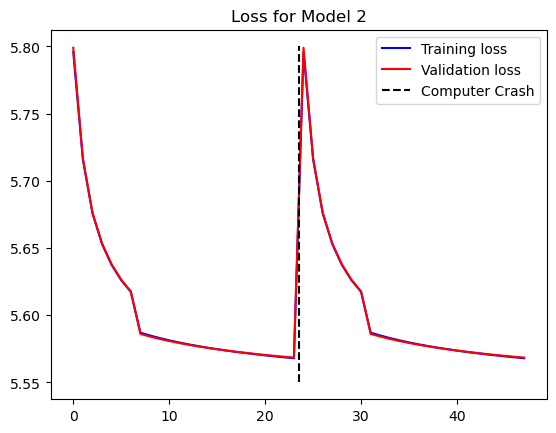

Final training loss: 5.568030221395926
Final validation loss: 5.568508148193359


In [40]:
train_loss_3 = [5.795922756195068, 5.716060638427734, 5.675954341888428, 5.652993679046631, 5.637449741363525, 5.626087188720703, 5.617416858673096, 5.5870568954752615, 5.5849507165688195, 5.58306241227453, 5.581355651859658, 5.57980357082138, 5.5783844819704225, 5.577080461326141, 5.575876704246722, 5.574760838448565, 5.573722521347672, 5.572752980676263, 5.571844811146291, 5.570991626421145, 5.570187989824164, 5.569429223394324, 5.568711155330105, 5.568030221395926, 5.795922756195068, 5.716060638427734, 5.675954341888428, 5.652993679046631, 5.637449741363525, 5.626087188720703, 5.617416858673096, 5.5870568954752615, 5.5849507165688195, 5.58306241227453, 5.581355651859658, 5.57980357082138, 5.5783844819704225, 5.577080461326141, 5.575876704246722, 5.574760838448565, 5.573722521347672, 5.572752980676263, 5.571844811146291, 5.570991626421145, 5.570187989824164, 5.569429223394324, 5.568711155330105, 5.568030221395926]
valid_loss_3 = [5.799070835113525, 5.7169508934021, 5.676379680633545, 5.653461933135986, 5.637903690338135, 5.626455783843994, 5.617713451385498, 5.586125373840332, 5.584168910980225, 5.58241605758667, 5.58082914352417, 5.579389572143555, 5.578066825866699, 5.576859474182129, 5.575737476348877, 5.574705123901367, 5.573742389678955, 5.572847843170166, 5.572007656097412, 5.571223735809326, 5.570484638214111, 5.569790363311768, 5.569129943847656, 5.56850814819336, 5.799070835113525, 5.7169508934021, 5.676379680633545, 5.653461933135986, 5.637903690338135, 5.626455783843994, 5.617713451385498, 5.586125373840332, 5.584168910980225, 5.58241605758667, 5.58082914352417, 5.579389572143555, 5.578066825866699, 5.576859474182129, 5.575737476348877, 5.574705123901367, 5.573742389678955, 5.572847843170166, 5.572007656097412, 5.571223735809326, 5.570484638214111, 5.569790363311768, 5.569129943847656, 5.568508148193359]

plt.plot(train_loss_3, label='Training loss', color='blue')
plt.plot(valid_loss_3, label="Validation loss", color='red')
plt.vlines(23.5,5.55,5.80, color='black', label='Computer Crash', linestyle='--')

plt.title('Loss for Model 2')
plt.legend()
plt.show()

print("Final training loss:", train_loss_3[-1])
print("Final validation loss:", valid_loss_3[-1])

Okay! So this makes me a bit sad, since it's clear from the figure I messed up training somehow when my computer crashed. Ignoring the obvious issue around epoch 23, we can see that the model is improving! It learns quickly then slowly tapers off. However, the loss function is pretty high overall, ranging between `5.80` and `5.50` over all epochs. I'm not sure how much more training will help, but this code ran for 2 days as-is and I can't spare any more time to run it. What makes me happy, however, is that the training and validation loss are nearly identical! This shows that the simple head I have is pretty good at its job. Let's see how it performs on some data! I replace the `<pad>` values with `_` so that the RoBERTa decoder doesn't throw errors.

In [140]:
import numpy as np

def test_model():
    for batch_idx in range(30):
        print(f"Dataset point #{batch_idx*32}")
        squad_bpes = load_object(f"Validation_32/validation_squad_bpes")
        validation_ans_idxs = load_object(f"Validation_32/validation_ans_idxs")
        validation_ans_lens = load_object(f"Validation_32/validation_ans_lens")

        squad_bpe = squad_bpes[batch_idx].unsqueeze(0)
        ans_idx = validation_ans_idxs[batch_idx][0].unsqueeze(0)
        ans_len = validation_ans_lens[batch_idx][0].unsqueeze(0)
        print("single element size:     ", squad_bpe.shape)

        print("\nFrom BPE encoding:")
        for i in range(len(squad_bpe[0][0])):
            if squad_bpe[0][0][i] == 1:
                squad_bpe[0][0][i] = 1215
        print(roberta.decode(squad_bpe[0][0]))
        print()

        model = SquadModel(512, 768) # N=512, H=768
        model.to('cuda') # Use GPU
        model.load_state_dict(torch.load('models/saved_model'))

        out = model.forward(squad_bpes[0])
        model_start_idx = torch.argmax(out[0][0].to('cpu'))
        model_end_idx = torch.argmax(out[1][0].to('cpu'))

        print("Model start:", model_start_idx)
        print("Model end:", model_end_idx)
        print()
        print("True start:", ans_idx)
        print("True end:", ans_idx + ans_len)
        print()

        print("\nTrue answer:")
        print(roberta.decode(squad_bpe[0][0][ans_idx:ans_idx+ans_len]))
        print()
        print("Model answer:")
        print(roberta.decode(squad_bpe[0][0][model_start_idx:model_end_idx]))
        print()
        print("\n\n\n\n\n")

with torch.no_grad():
    test_model()

Dataset point #0
single element size:      torch.Size([1, 32, 512])

From BPE encoding:
Which NFL team represented the AFC at Super Bowl 50?Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50._____________________________________________________________________________________

Cool! So the model works how we expect it to, giving us a start and end index to the tokens which we can decode to give us our answer. Unfortunately, the model isn't very accurate, which explains the high loss we saw before. I wonder if it's a coincidence if the first answer was correct? I'm not sure... Either way, I'm super glad that the model training and inference works!

Now we can try to improve the model. One way to do this is to add a densely connected layer at the head of the model. My vision is to turn the 768\*512 output to a single vector and use that as the first layer of neurons. Then, I'll turn it into a larger layer of 768\*512\*2 and then back down to 768\*512. Unfortunately, my computer doesn't have the RAM to do this, as seen below. It's asking for over 618 GB of RAM. So, I think the next best thing would be a scaled down MLP, but if we're reducing the dimensions of the output of RoBERTa, then we're effectively trekking into bottleneck territory, which we showed earlier is not always good.

In [143]:
# Our custom RoBERTa head
class SquadModel2(nn.Module):
    def __init__(self, input_len, hidden_dim):
        self.input_len = input_len
        self.hidden_dim = hidden_dim
        super(SquadModel2, self).__init__()
        
        self.S = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)
        self.E = nn.Parameter(torch.ones(self.hidden_dim, requires_grad=True)/self.hidden_dim)
        
        self.fc1 = nn.Linear(768*512, 768*512*2)
        self.fc2 = nn.Linear(768*512*2, 768*512)

    def forward(self, x):
        with torch.no_grad(): # Saves GPU memory since we aren't keeping track of gradients
            x = roberta.extract_features(x) # BPE Squad input
        x = torch.swapdims(x, 1, 2) # Correct dimensions so that matrix multiplication works
        
        # Densely connected layers
        with torch.no_grad():
            saved_shape = x.shape
        x = x.reshape(x.shape[0], 1, -1)
        x = F.ReLU(self.fc1(x))
        x = F.ReLU(self.fc2(x))
        x = x.reshape(saved_shape)
        
        # Classicfication
        start = self.S @ x
        start = F.softmax(start,dim=0)
        
        end = self.E @ x
        end = F.softmax(end,dim=0)
        return start, end

model = SquadModel2(512, 768) # N=512, H=768
model.to('cuda') # Use GPU
optimizer = optim.Adam(model.parameters(), lr=0.0001)
None

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 1236950581248 bytes. Error code 12 (Cannot allocate memory)

So, I'll call off the report here!

## Conclusion

Overall, I'm really happy with this report. I learned a lot about a lot lol. I learned about the details and mathematical operations of the encoder. I did some dataset pre-processing to speed up my model training time. I also did some model pre-training using some provided code which I modified the hyper-parameters of. I compared the effects of a bottleneck and inverted bottleneck for RoBERTa and concluded the inverted bottleneck was better. I also added a question-answering head to BERT.

Future explorations would be analyzing the GPT model and how a decoder works in detail (although it's very similar to the encoder). Trying out different pre-training regimes. Fine-tuning the model would be interesting to explore as well. Also, modifying the SQuAD head to perform better (with maybe a MLP) would be better. Further, different heads for different problems could be explored.

Thanks for reading!